## Devices Classifier with RandomForest 

In [17]:
# Suggestion: use a python virtual env
# $ conda create -n nprint python=3.8
# $ conda activate nprint
# switch juypter kernel to nprint-wlan venv

# Requirement Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

from collections import Counter

# Project files
from mac_vendor import *

In [4]:
# Train Pcap: without .pcap suffix
train_file = 'wlan_2020_11_05_03'
# Test Pcap: could be the same as train_file
test_file = 'wlan_2020_11_05_02'

## Training

In [ ]:
cmd_test = f'../nprint -w -P {train_file}.pcap -W {train_file}.npt'
!{cmd_test}

In [20]:
nprint_wlan = pd.read_csv(f'{train_file}.npt', index_col=0)
print('nPrint_wlan: Number of Packets: {0}, Features per packet: {1}'.format(nprint_wlan.shape[0], nprint_wlan.shape[1]))

nprint_wlan_with_src_mac = nprint_wlan.loc[nprint_wlan.index != 'None']
print('nprint_wlan_with_src_mac: Number of Packets: {0}, Features per packet: {1}'.format(nprint_wlan_with_src_mac.shape[0], nprint_wlan_with_src_mac.shape[1]))

num_sample_packets = nprint_wlan_with_src_mac.shape[0]

top_10_vendors = get_top_vendors(nprint_wlan, 10)
print(f'Top 10 vendors: {top_10_vendors}')

samples, labels, samples_without_vendor = label_packets(nprint_wlan_with_src_mac, top_10_vendors)
print(f'Samples: {len(samples)}, Features: {len(samples[0])}')
print(f'Samples without Vendor label: {len(samples_without_vendor)}')

nPrint_wlan: Number of Packets: 4422, Features per packet: 528
nprint_wlan_with_src_mac: Number of Packets: 3910, Features per packet: 528
Top 10 vendors: ['Motorola', 'eero', 'ARRISGro', '2Wire', 'Google', 'HewlettP', 'ASUSTekC', 'Pegatron', 'Tp-LinkT', 'BelkinIn']
Samples: 3141, Features: 528
Samples without Vendor label: 769


In [21]:
X_train, X_test, y_train, y_test = train_test_split(samples, labels)
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2, random_state=0)
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       2Wire       0.88      1.00      0.94       101
    ARRISGro       0.90      0.99      0.94       102
    ASUSTekC       1.00      0.98      0.99        48
    BelkinIn       0.78      0.78      0.78         9
      Google       0.96      0.97      0.97        75
    HewlettP       0.96      0.98      0.97        50
    Motorola       1.00      0.96      0.98       186
      Others       0.95      0.70      0.81        30
    Pegatron       1.00      0.85      0.92        20
    Tp-LinkT       1.00      0.72      0.84        25
        eero       1.00      1.00      1.00       140

    accuracy                           0.96       786
   macro avg       0.95      0.90      0.92       786
weighted avg       0.96      0.96      0.96       786



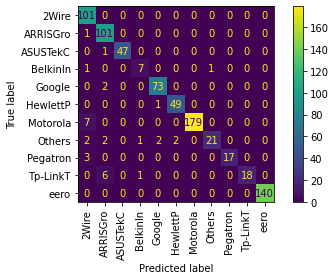

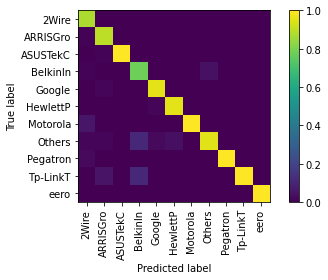

In [22]:
plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.tight_layout()
# plt.savefig('../imgs/sample-2_01.png', transparent=False, facecolor='white')
plt.show()

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical', normalize='pred', include_values=False)
plt.tight_layout()
# plt.savefig('../imgs/sample-2_02.png', transparent=False, facecolor='white')
plt.show()

## Testing with new Pcaps

In [32]:
cmd_test = f'../nprint -w -P {test_file}.pcap -W {test_file}.npt'
!{cmd_test}

nprint_wlan_test = pd.read_csv(f'{test_file}.npt', index_col=0)
print('Number of Packets: {0}, Features per packet: {1}'.format(nprint_wlan_test.shape[0], nprint_wlan_test.shape[1]))

nprint_wlan_test_with_src_mac = nprint_wlan_test.loc[nprint_wlan_test.index != 'None']
print('Number of Packets with src mac: {0}'.format(nprint_wlan_test_with_src_mac.shape[0]))

test_samples, test_labels, test_samples_without_vendor = label_packets(nprint_wlan_test_with_src_mac, top_10_vendors)

print(f'Test Samples: {len(test_samples)}, Features: {len(test_samples[0])}')
print(f'Test Samples without Vendor label: {len(test_samples_without_vendor)}')

Number of Packets: 4782, Features per packet: 528
Number of Packets with src mac: 4754
Test Samples: 4730, Features: 528
Test Samples without Vendor label: 24


In [33]:
y_test_pred = clf.predict(test_samples)
report = classification_report(test_labels, y_test_pred)
print(report)

              precision    recall  f1-score   support

    ARRISGro       0.00      0.00      0.00         0
    ASUSTekC       0.00      0.00      0.00         0
      Google       0.59      0.98      0.74       470
    HewlettP       0.96      0.52      0.68       633
      Others       0.20      0.04      0.07        23
        eero       1.00      1.00      1.00      3604

    accuracy                           0.93      4730
   macro avg       0.46      0.42      0.41      4730
weighted avg       0.95      0.93      0.93      4730



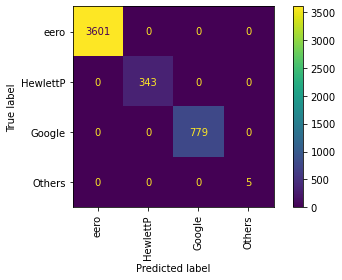

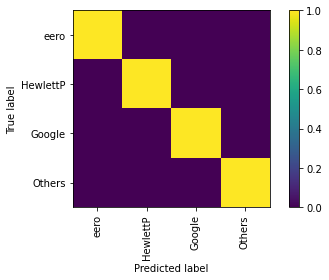

In [34]:
test_vendor_counter = Counter([get_vendor(row.name) for _, row in nprint_wlan_test_with_src_mac.iterrows()])
test_labels = [vendor for vendor, _ in test_vendor_counter.most_common() if vendor in top_10_vendors]
test_labels.append('Others')

plot_confusion_matrix(clf, test_samples, y_test_pred, labels=test_labels, xticks_rotation='vertical')
plt.tight_layout()
plt.show()

plot_confusion_matrix(clf, test_samples, y_test_pred, labels=test_labels, xticks_rotation='vertical', normalize='pred', include_values=False)
plt.tight_layout()
plt.show()